In [16]:
## ===============================================
#  CORE LIBRARIES
# ===============================================
import pandas as pd
import numpy as np
import os
import glob
import gc # Garbage Collector

## ===============================================
#  MACHINE LEARNING & DEEP LEARNING
# ===============================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix # <-- FIX IS HERE
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, SpatialDropout1D, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## ===============================================
#  SETTINGS
# ===============================================
import warnings
warnings.filterwarnings('ignore')

print(f"✅ All libraries imported! (TensorFlow version: {tf.__version__})")

✅ All libraries imported! (TensorFlow version: 2.16.2)


In [2]:
# --- 1. Load and process text-based datasets ---
df_urls = pd.read_csv('malicious_urls.csv')
df_xss = pd.read_csv('XSS_dataset.csv').rename(columns={'Sentence': 'text', 'Label':'is_malicious'})
df_sql = pd.read_csv('SQL_Injection_dataset.csv').rename(columns={'Query': 'text', 'Label':'is_malicious'})

# Combine all text data into a single DataFrame
df_urls['label'] = df_urls['type'].apply(lambda x: 'Benign' if x == 'benign' else 'Malicious_URL')
df_xss['label'] = df_xss['is_malicious'].apply(lambda x: 'XSS' if x == 1 else 'Benign')
df_sql['label'] = df_sql['is_malicious'].apply(lambda x: 'SQL_Injection' if x == 1 else 'Benign')
df_urls.rename(columns={'url': 'text'}, inplace=True)
df_text = pd.concat([df_urls[['text', 'label']], df_xss[['text', 'label']], df_sql[['text', 'label']]], ignore_index=True).dropna()
print(f"Loaded {len(df_text)} text-based samples.")

# --- 2. Load and process network-based dataset ---
data_path = 'CSIC 2018/MachineLearningCVE/'
all_files = glob.glob(os.path.join(data_path, "*.csv"))
if not all_files:
    raise FileNotFoundError(f"CRITICAL ERROR: No CSV files found in '{data_path}'.")
df_network_full = pd.concat((pd.read_csv(f, low_memory=False) for f in all_files), ignore_index=True)

# Clean and subsample the network data
df_network_full.columns = df_network_full.columns.str.strip()
df_network_full.rename(columns={'Label': 'label'}, inplace=True)
df_network_full.replace([np.inf, -np.inf], np.nan, inplace=True)
df_network_full.dropna(inplace=True)
df_network = df_network_full.sample(n=250000, random_state=42) # Subsample for speed
del df_network_full
gc.collect()
print(f"Loaded and subsampled {len(df_network)} network samples.")

# --- 3. Create a unified label set for both datasets ---
all_labels = pd.concat([df_text['label'], df_network['label']], ignore_index=True)
le = LabelEncoder()
le.fit(all_labels)
num_classes = len(le.classes_)

# Apply the unified encoder to each dataframe
df_text['label_encoded'] = le.transform(df_text['label'])
df_network['label_encoded'] = le.transform(df_network['label'])

print(f"\n✅ Data loaded and labels unified across {num_classes} classes.")

Loaded 695795 text-based samples.
Loaded and subsampled 250000 network samples.

✅ Data loaded and labels unified across 18 classes.


In [8]:
# --- Filter out classes with only one sample ---
text_label_counts = df_text['label'].value_counts()
network_label_counts = df_network['label'].value_counts()
text_labels_to_remove = text_label_counts[text_label_counts < 2].index
network_labels_to_remove = network_label_counts[network_label_counts < 2].index
df_text_filtered = df_text[~df_text['label'].isin(text_labels_to_remove)]
df_network_filtered = df_network[~df_network['label'].isin(network_labels_to_remove)]
print(f"Filtered {len(text_labels_to_remove)} rare classes from text data.")
print(f"Filtered {len(network_labels_to_remove)} rare classes from network data.")

# --- 1. Prepare Text Data ---
MAX_WORDS = 15000
MAX_LEN = 100
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df_text_filtered['text'])
X_text_seq = tokenizer.texts_to_sequences(df_text_filtered['text'])
X_text_pad = pad_sequences(X_text_seq, maxlen=MAX_LEN)
y_text_encoded = le.transform(df_text_filtered['label'])

# --- 2. Prepare Network Data ---
X_network_raw = df_network_filtered.drop(['label', 'label_encoded'], axis=1)
y_network_encoded = df_network_filtered['label_encoded'].values
scaler = StandardScaler()
X_network_scaled = scaler.fit_transform(X_network_raw)

# --- 3. Create Final Master Arrays ---
# Create a text array that includes zero-placeholders for the network data
X_text_master = np.concatenate([
    X_text_pad,
    np.zeros((X_network_scaled.shape[0], MAX_LEN))
])

# Create a network array that includes zero-placeholders for the text data
X_network_master = np.concatenate([
    np.zeros((X_text_pad.shape[0], X_network_scaled.shape[1])),
    X_network_scaled
])

# Create the master labels array
y_master = np.concatenate([y_text_encoded, y_network_encoded])
y_master_cat = to_categorical(y_master, num_classes=num_classes)


print("\n✅ Master data arrays created successfully.")
print(f"Master Text Input Shape: {X_text_master.shape}")
print(f"Master Network Input Shape: {X_network_master.shape}")
print(f"Master Labels Shape: {y_master_cat.shape}")

Filtered 0 rare classes from text data.
Filtered 1 rare classes from network data.

✅ Master data arrays created successfully.
Master Text Input Shape: (945794, 100)
Master Network Input Shape: (945794, 78)
Master Labels Shape: (945794, 18)


In [9]:
# --- Perform a single, clean train-test split ---
X_train_text, X_test_text, \
X_train_network, X_test_network, \
y_train, y_test = train_test_split(
    X_text_master,
    X_network_master,
    y_master_cat,
    test_size=0.2,
    random_state=42,
    stratify=y_master_cat # Stratify on the final labels
)

print("✅ Data split successfully.")
print(f"X_train_text shape: {X_train_text.shape}")
print(f"X_test_network shape: {X_test_network.shape}")
print(f"y_test shape: {y_test.shape}")

✅ Data split successfully.
X_train_text shape: (756635, 100)
X_test_network shape: (189159, 78)
y_test shape: (189159, 18)


In [10]:
# --- Define the optimizer with a lower learning rate and gradient clipping ---
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)

# --- Branch 1: GRU for Text Data ---
text_input = Input(shape=(MAX_LEN,), name='text_input')
embedding = Embedding(input_dim=MAX_WORDS, output_dim=128)(text_input)
spatial_dropout = SpatialDropout1D(0.3)(embedding)
gru_output = GRU(128)(spatial_dropout)
text_branch = Dense(64, activation='relu')(gru_output)

# --- Branch 2: DNN for Network Data ---
network_input = Input(shape=(X_train_network.shape[1],), name='network_input')
dense_1 = Dense(128, activation='relu')(network_input)
dense_2 = Dense(64, activation='relu')(dense_1)
network_branch = Dense(32, activation='relu')(dense_2)

# --- Merge the branches ---
merged = concatenate([text_branch, network_branch])
merged_dense = Dense(64, activation='relu')(merged)
output = Dense(num_classes, activation='softmax', name='output')(merged_dense)

# --- Create and compile the final model ---
model = Model(inputs=[text_input, network_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 128)  │  1,920,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ network_input       │ (None, 78)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 100, 128)  │          0 │ embedding_1[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     10,112 │ network_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 128)       │     99,072 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      2,080 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ dense_5[0][0],    │
│ (Concatenate)       │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      6,208 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 18)        │      1,170 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,055,154 (7.84 MB)

 Trainable params: 2,055,154 (7.84 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# --- Define EarlyStopping callback ---
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# --- Define the optimizer with a stable learning rate ---
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)

# --- Re-compile the model with the new optimizer ---
# (It's good practice to re-run the build and compile steps together)

# --- Branch 1: GRU for Text Data ---
text_input = Input(shape=(MAX_LEN,), name='text_input')
embedding = Embedding(input_dim=MAX_WORDS, output_dim=128)(text_input)
spatial_dropout = SpatialDropout1D(0.3)(embedding)
gru_output = GRU(128)(spatial_dropout)
text_branch = Dense(64, activation='relu')(gru_output)

# --- Branch 2: DNN for Network Data ---
network_input = Input(shape=(X_train_network.shape[1],), name='network_input')
dense_1 = Dense(128, activation='relu')(network_input)
dense_2 = Dense(64, activation='relu')(dense_1)
network_branch = Dense(32, activation='relu')(dense_2)

# --- Merge the branches ---
merged = concatenate([text_branch, network_branch])
merged_dense = Dense(64, activation='relu')(merged)
output = Dense(num_classes, activation='softmax', name='output')(merged_dense)

# --- Create and compile the final model ---
model = Model(inputs=[text_input, network_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# --- Train the model ---
print("\n🚀 Training the Multi-Input Model...")
history = model.fit(
    [X_train_text, X_train_network], # Pass the split inputs directly
    y_train,
    epochs=10,
    batch_size=1024,
    validation_split=0.15,
    callbacks=[early_stopping],
    verbose=1
)

print("\n✅ Training complete!")


🚀 Training the Multi-Input Model...
Epoch 1/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 60s 92ms/step - accuracy: 0.7962 - loss: 0.6962 - val_accuracy: 0.9230 - val_loss: 0.2357
Epoch 2/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9360 - loss: 0.1868 - val_accuracy: 0.9444 - val_loss: 0.1578
Epoch 3/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.9487 - loss: 0.1483 - val_accuracy: 0.9515 - val_loss: 0.1411
Epoch 4/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.9535 - loss: 0.1361 - val_accuracy: 0.9547 - val_loss: 0.1324
Epoch 5/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.9561 - loss: 0.1303 - val_accuracy: 0.9549 - val_loss: 0.1346
Epoch 6/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 59s 93ms/step - accuracy: 0.9566 - loss: 0.1296 - val_accuracy: 0.9565 - val_loss: 0.1326

✅ Training complete!



--- Multi-Input Model Evaluation ---
Test Accuracy: 0.9545
Test Loss: 0.1330

5912/5912 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
Classification Report:
                          precision    recall  f1-score   support

                  BENIGN       0.96      0.98      0.97     40117
                  Benign       0.96      0.98      0.97     90791
                     Bot       0.00      0.00      0.00        31
                    DDoS       0.98      0.84      0.90      2281
           DoS GoldenEye       0.82      0.36      0.50       191
                DoS Hulk       0.94      0.78      0.85      4093
        DoS Slowhttptest       0.73      0.52      0.61       102
           DoS slowloris       0.53      0.24      0.33       101
             FTP-Patator       0.00      0.00      0.00       154
           Malicious_URL       0.96      0.91      0.94     44618
                PortScan       0.77      0.99      0.87      2780
           SQL_Injection       0.99      0.97      0.98      

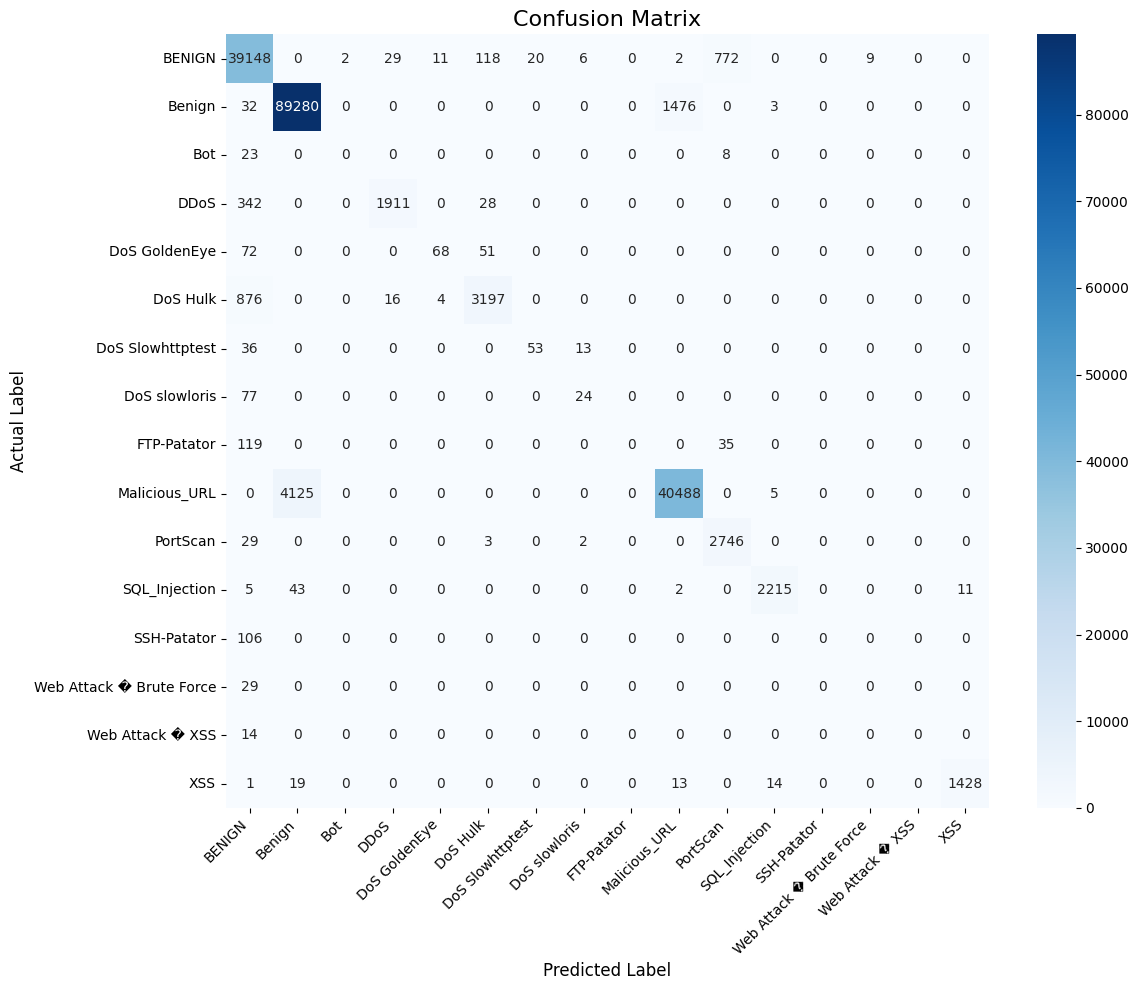

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Evaluate the model's performance on the unseen test set ---
loss, accuracy = model.evaluate([X_test_text, X_test_network], y_test, verbose=0)
print("\n--- Multi-Input Model Evaluation ---")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}\n")

# --- Generate predictions ---
y_pred_probs = model.predict([X_test_text, X_test_network])
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# --- Generate the Classification Report ---
# Find all unique class labels that are actually in the test results
active_labels = np.unique(np.concatenate((y_test_classes, y_pred)))
# Get the corresponding names for these active labels
active_target_names = le.inverse_transform(active_labels)

print("Classification Report:")
print(classification_report(
    y_test_classes,
    y_pred,
    labels=active_labels,
    target_names=active_target_names,
    zero_division=0
))

# --- Generate and Plot the Confusion Matrix ---
print("\nGenerating Confusion Matrix...")
conf_matrix = confusion_matrix(y_test_classes, y_pred, labels=active_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=active_target_names,
            yticklabels=active_target_names)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to make room for rotated labels
plt.show()

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_user_input(text_input_string, model, tokenizer, le, network_input_shape, max_len):
    """
    Takes a user's text string and all necessary model components,
    preprocesses it, and returns the model's prediction.
    """
    # 1. Preprocess the text input
    text_seq = tokenizer.texts_to_sequences([text_input_string])
    text_pad = pad_sequences(text_seq, maxlen=max_len, padding='post')

    # 2. Create a dummy zero-input for the second network branch
    network_dummy_input = np.zeros((1, network_input_shape))

    # 3. Make a prediction
    prediction_probs = model.predict([text_pad, network_dummy_input], verbose=0)

    # 4. Decode the prediction
    predicted_class_index = np.argmax(prediction_probs[0])
    predicted_class_label = le.inverse_transform([predicted_class_index])[0]

    # 5. Return both label and confidence score
    return predicted_class_label, float(prediction_probs[0][predicted_class_index])

# --- Interactive Testing Loop ---
print("\n--- 🕵️‍♂️ Real-Time Prediction Engine ---")
print("Enter a URL or text string to classify it. Type 'exit' to quit.")

while True:
    user_input = input("\nEnter text: ")
    if user_input.lower() == 'exit':
        print("Exiting prediction engine.")
        break

    if not user_input.strip():
        print("Please enter some text.")
        continue

    # Predict and print results
    label, confidence = predict_user_input(
        user_input,
        model,
        tokenizer,
        le,
        X_train_network.shape[1],  # network_input_shape
        MAX_LEN                    # max_len
    )
    print(f"➡️ Prediction: '{label}' (Confidence: {confidence:.2%})")



--- 🕵️‍♂️ Real-Time Prediction Engine ---
Enter a URL or text string to classify it. Type 'exit' to quit.


NameError: name 'model' is not defined